# Domain Adaptation For Emotion Transfer

## Imports and Dependencies

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
!pip install transformers==4.24.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install torchsummaryX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install -U scikit-learn
!pip install python-Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import torch
import transformers
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchsummaryX import summary
from torch.utils.data import Dataset, DataLoader
import zipfile
import pandas as pd
from tqdm import tqdm
import os
import datetime
import warnings
import Levenshtein

#Dataset Imports
import csv
from IPython.display import Audio, display
import torchaudio
from transformers import Wav2Vec2FeatureExtractor
from torch.nn.utils.rnn import pad_sequence

warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


In [8]:
import gc
gc.collect()

0

In [9]:
torch.cuda.empty_cache()

In [10]:
!nvidia-smi

Thu Dec 15 23:18:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    50W / 400W |      3MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
print(transformers.__version__)

4.24.0


## Dataloaders

In [12]:
# {'A':1, 'S':2, 'H':3, 'U':4, 'F':5, 'D':6, 'C':7, 'N':8, 'O':9}
EMOMAP = {'A':0, 'S':1, 'H':2,'D':3,'N':4}

In [13]:
NSC_ASR_Root = '/home/ubuntu/data/NSC/'
NSC_test_dataset = '/home/ubuntu/data/NSC/NSC_part5_labelled_emotion/'

In [14]:
from transformers import Wav2Vec2Processor
model_name_or_path = "facebook/wav2vec2-base-960h"
processor = Wav2Vec2Processor.from_pretrained(model_name_or_path,)
target_sampling_rate = processor.feature_extractor.sampling_rate
print(target_sampling_rate)

16000


In [15]:
class NSCSpeechDatasetASR(torch.utils.data.Dataset):
    
    def __init__(self): 
        
        self.audio_dir = NSC_ASR_Root + 'top20k/'
        self.labels_dir = NSC_ASR_Root + 'text'
        self.audio = []
        self.labels = []
        self.audio = sorted(os.listdir(self.audio_dir)[0:1000])

        #Get the correct labels for the 20000 that we have.
        with open(self.labels_dir) as f:
            lines = f.readlines()
            start = False
            for l in lines:
                idx = int(l[4:8])
                #Start at APP_4001 and take 20000 from there
                if idx >= 4001 and len(self.labels) != len(self.audio):
                    #Remove new line and extract transcript
                    self.labels.append(l[:-1].split(" ", 1))
        print(len(self.audio))
        print(len(self.labels))
        assert(len(self.audio) == len(self.labels))
        self.length = len(self.audio)
        #Sanity Check!
        #Could be commented out..
        # for i in range(len(self.audio)):
        #     if(self.audio[i][:-4] != self.labels[i][0]):
        #         print(self.audio[i])
        #         print(self.labels[i][0])
        #         break
                
        self.labels = [x[1] for x in self.labels][0:1000]

    def __len__(self):
        return self.length

    def __getitem__(self, ind):
        audio = self.audio[ind]
        #Sanity Check
        #print(audio)
        label = self.labels[ind]
        #frame_offset, num_frames = 0, 10000
        #load audio when getting the item. If we do it in init, computer blue screens.
        waveform, sample_rate = torchaudio.load(self.audio_dir + audio)
        #print(sample_rate)
        waveform = processor(waveform, sampling_rate = 16000,padding=True, return_tensors="pt", device = device)
        # waveform = waveform.to(device)
        # frame_offset, num_frames = 16000, 16000
        # waveform = waveform[:, frame_offset:frame_offset+num_frames]
        # label = label.to(device)
        waveform['labels'] = label

        return waveform

In [16]:
class NSCDatasetEmotion(torch.utils.data.Dataset):
    
    def __init__(self): 
        
        audio_dir = NSC_test_dataset
        #quick way of looping subdirectories. Dataset only has 4 categories. 
        subdirectory = [('Anger/', 0), ('Sad/', 1), ('Happy/', 2), ('Neutral/', 4)]
        self.audio = []
        self.labels = []
        for sub, label in subdirectory:
            print(audio_dir + sub)
            NSCaudios = os.listdir(audio_dir + sub)
            self.audio += [audio_dir + sub + x for x in NSCaudios[0:20]]
            self.labels += [label]*len(NSCaudios[0:20]) 
        #Sanitycheck1
        assert(len(self.audio) == len(self.labels))
        self.length = len(self.audio)
        
        #self.audio = 
        
    def __len__(self):
        return self.length

    def __getitem__(self, ind):
        audio = self.audio[ind]
        label = self.labels[ind]
        #load audio when getting the item. If we do it in init, computer blue screens.
        waveform, sample_rate = torchaudio.load(audio)
        waveform = processor(waveform, sampling_rate = 16000,padding=True, return_tensors="pt", device = device)
        # waveform = waveform.to(device)
        # label = label.to(device)
        waveform['labels'] = label

        return waveform
        #return waveform, label

In [17]:
# NSCTest = NSCDatasetEmotion()
# NSCTest[0]
# NSCtest_dataset = Dataset.from_list(NSCTest)

# #stratified sort to train/test splits. Requires encoding the columns to classes first.
# NSCtest_dataset2 = NSCtest_dataset.class_encode_column('labels')
# #NSCtest_dataset2.train_test_split(test_size = 0.1, stratify_by_column = 'labels')

In [18]:
from datasets import load_dataset
MSP_podcast_train = load_dataset("dlproject/msp_train_hubert")
MSP_podcast_val = load_dataset("dlproject/msp_val_hubert")

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
# NSCSpeech = NSCSpeechDatasetASR()
# from datasets import load_dataset
NSCSpeech = load_dataset("dlproject/nsc_batches")
# for i in NSCSpeech:
#     print(i['input_values'].shape)

  0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
NSCTest = load_dataset("dlproject/nsc_test")

  0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
from torch.utils.data import DataLoader
#NSCSpeech = DataLoader(NSCSpeech['train'], batch_size=1)

In [22]:
# for i in NSCSpeech['train']:
#   print(i)

## Create Batches

In [24]:
def collate(features):
    # split inputs and labels since they have to be of different lengths and need
    # different paddig methods
    #print(features)
    input_features = [{"input_values": feature[0]} for feature in features['input_values'][0:len(features['input_values'])//2]]
    #label_features = [{"input_ids": label} for label in features['labels']]

    #print(label_features)
    batch_emotion = processor.pad(input_features, padding=True,return_tensors="pt")

    #labels_batch = processor.pad(labels=label_features, padding=True, return_tensors="pt")

    # replace padding with -100 to ignore loss correctly
    #labels = features['labels'].masked_fill(features['labels'].attention_mask.ne(1), -100)

    batch_emotion["labels"] = features['labels'][0:len(features)//2]
    batch_emotion["types"] = features['types'][0:len(features)//2]
    input_features_asr = [{"input_values": feature[0]} for feature in features['input_values'][len(features['input_values'])//2:len(features['input_values'])]]
    #label_features = [{"input_ids": label} for label in features['labels']]

    #print(label_features)
    batch_asr = processor.pad(input_features_asr, padding=True,return_tensors="pt")

    #labels_batch = processor.pad(labels=label_features, padding=True, return_tensors="pt")

    # replace padding with -100 to ignore loss correctly
    #labels = features['labels'].masked_fill(features['labels'].attention_mask.ne(1), -100)

    batch_asr["labels"] = features['labels'][len(features['input_values'])//2:len(features['input_values'])]
    batch_asr["types"] = features['types'][len(features['input_values'])//2:len(features['input_values'])]

    #print(batch_emotion['input_values'].shape)
    #print(batch_asr)
    return batch_emotion, batch_asr

In [25]:
import string
alpha = list(string.ascii_uppercase)
vocab = alpha + ["<sos>","<eos>","<unk>"," "]

vocab2id = dict(zip(vocab,range(30)))

In [26]:
def create_combined_batches(batch_size):
    num_batches = (MSP_podcast_train['train'].num_rows + len(NSCSpeech['train']))//batch_size
    #num_batches = (100 + NSCSpeech.length)//batch_size
    combined_batches = []
    print(num_batches)
    for i in tqdm(range(num_batches)):
        final_batch = {}
        
        batch_input_values = []
        batch_labels = []
        batch_types = []
       # try:
        for record in range(batch_size//2):
            batch_input_values.append({"input_values":torch.tensor(MSP_podcast_train['train'][i+record]['input_values'][0]).squeeze(0)})
            batch_labels.append(MSP_podcast_train['train'][i+record]['labels'])
            batch_types = ['emotion'] * (batch_size//2)
    
        #print(len(batch_input_values))
        batch_emotion = processor.pad(batch_input_values,padding='max_length',truncation=True,max_length=10000, return_tensors="pt")
        batch_emotion['labels'] = batch_labels
        batch_emotion['types'] = batch_types
        #combined_batches.append(batch_emotion)
        
        batch_input_values = []
        batch_labels = []
        batch_types = []
        for record in range(batch_size//2):
            #print(i+record)
            batch_input_values.append({"input_values":torch.tensor(NSCSpeech['train'][i+record]['input_values'][0]).squeeze(0)})
            batch_labels.append([vocab2id.get(x,29) for x in NSCSpeech['train'][i+record]['labels']])
            batch_types = ['asr'] * (batch_size//2)
       
        batch_asr = processor.pad(batch_input_values,padding='max_length',truncation=True,max_length=10000, return_tensors="pt")
        batch_asr['labels'] = batch_labels
        batch_asr['types'] = batch_types

        final_batch['input_values'] = torch.vstack((batch_emotion['input_values'],batch_asr['input_values']))
        final_batch['labels'] = batch_emotion['labels'] + batch_asr['labels']
        final_batch['types'] = batch_emotion['types'] + batch_asr['types']

        combined_batches.append(final_batch)
        del batch_emotion, batch_asr
    return combined_batches

In [27]:
combined_batches = create_combined_batches(32)

1248


100%|██████████| 1248/1248 [42:40<00:00,  2.05s/it]


In [33]:
import numpy as np
from transformers import EvalPrediction
from torchmetrics import F1Score

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.argmax(preds, axis=1)

    f1 = F1Score(num_classes=5,average='weighted')
    return {"accuracy": (preds == p.label_ids).astype(np.float32).mean().item(), "f1": f1(torch.tensor(preds), torch.tensor(p.label_ids))}

## Model

In [34]:
# config
from transformers import AutoConfig, Wav2Vec2Processor
pooling_mode = "mean"
model_name_or_path = "facebook/hubert-base-ls960"
config = AutoConfig.from_pretrained(
    model_name_or_path,
    num_labels=len(EMOMAP),
    label2id=EMOMAP,
    hidden_size=768,
    id2label={i: label for label,i in EMOMAP.items()},
    finetuning_task="wav2vec2_clf",
)
setattr(config, 'pooling_mode', pooling_mode)


In [35]:
from dataclasses import dataclass
from typing import Optional, Tuple
import torch
from transformers.file_utils import ModelOutput


@dataclass
class SpeechClassifierOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None


In [36]:
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

from transformers.models.wav2vec2.modeling_wav2vec2 import (
    Wav2Vec2PreTrainedModel,
    Wav2Vec2Model
)


class Wav2Vec2ClassificationHead(nn.Module):
    """Head for wav2vec classification task."""

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.final_dropout)
        self.out_proj = nn.Linear(config.hidden_size, len(EMOMAP))

    def forward(self, features, **kwargs):
        x = features
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x


class Wav2Vec2ForSpeechClassification(Wav2Vec2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.pooling_mode = config.pooling_mode
        self.config = config

        self.wav2vec2 = Wav2Vec2Model(config)
        self.classifier = Wav2Vec2ClassificationHead(config)

        self.init_weights()

    def freeze_feature_extractor(self):
        self.wav2vec2.feature_extractor._freeze_parameters()

    def merged_strategy(
            self,
            hidden_states,
            mode="mean"
    ):
        if mode == "mean":
            outputs = torch.mean(hidden_states, dim=1)
        elif mode == "sum":
            outputs = torch.sum(hidden_states, dim=1)
        elif mode == "max":
            outputs = torch.max(hidden_states, dim=1)[0]
        else:
            raise Exception(
                "The pooling method hasn't been defined! Your pooling mode must be one of these ['mean', 'sum', 'max']")

        return outputs

    def forward(
            self,
            input_values,
            attention_mask=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
            labels=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.wav2vec2(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = outputs[0]
        hidden_states = self.merged_strategy(hidden_states, mode=self.pooling_mode)
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SpeechClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


In [37]:
from transformers import Wav2Vec2Processor,HubertModel, HubertForCTC,HubertForSequenceClassification
feature_model = HubertModel.from_pretrained(
    "facebook/hubert-base-ls960",
    config=config,
    ignore_mismatched_sizes=True,
)
#feature_model.freeze_feature_extractor()
for n,p in feature_model.named_parameters():
  if "feature_extractor" in n:
    p.requires_grad = False 

emotion_classifier_model = Wav2Vec2ClassificationHead(config).to(device)
# ## Add a simple class head on top of feature_model for ASR and emotion.

# emotion_classifier_model = HubertForSequenceClassification.from_pretrained(
#     "facebook/hubert-base-ls960",
#     config=config,
#     ignore_mismatched_sizes=True,
# ).to(device)
#emotion_classifier_model.freeze_feature_extractor()

ctc_model_for_asr = torch.nn.Sequential(
    nn.Linear(768,len(vocab)),
    nn.LogSoftmax(-1)
)

In [38]:
mem_params = sum([param.nelement()*param.element_size() for param in feature_model.parameters()])
mem_bufs = sum([buf.nelement()*buf.element_size() for buf in feature_model.buffers()])
mem = mem_params + mem_bufs # in bytes

In [48]:
from transformers import AutoModelForCTC

In [50]:
from torch.autograd import Function
class GradientReversalFunction(Function):
    """
    Gradient Reversal Layer from:
    Unsupervised Domain Adaptation by Backpropagation (Ganin & Lempitsky, 2015)
    Forward pass is the identity function. In the backward pass,
    the upstream gradients are multiplied by -lambda (i.e. gradient is reversed)
    """

    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_

        return x.clone()

    @staticmethod
    def backward(ctx, grads):
        lambda_ = ctx.lambda_
        lambda_ = grads.new_tensor(lambda_)
        dx = -lambda_ * grads

        return dx, None

class GradientReversal(torch.nn.Module):
    def __init__(self, lambda_=1):
        super(GradientReversal, self).__init__()

        self.lambda_ = lambda_

    def forward(self, x):

        return GradientReversalFunction.apply(x, self.lambda_)

In [51]:
class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

In [52]:
class DomainClassifier(nn.Module):
    
    def __init__(self):
        super(DomainClassifier, self).__init__()
        
        domain_weight = 3
        
        hidden_size = 1024
        self.grl = GradientReversal(domain_weight)
        
        self.linear_1 = nn.Linear(768, 768)
        self.linear_2 = nn.Linear(768, 2)
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()


    def forward(self, x):
        x = self.grl(x)
        x = self.relu(self.linear_1(x))
        x = self.softmax(self.linear_2(x))

        return x

In [53]:
import torch.nn as nn
# from functions import ReverseLayerF


class DomainAdaptationModelForAccentedSpeech(nn.Module):

    def __init__(self):
        super(DomainAdaptationModelForAccentedSpeech, self).__init__()
        
        # Feature Extractor Model
        self.feature = feature_model.to(device)

        self.class_classifier = emotion_classifier_model
        #self.class_classifier = self.
        
        # ASR Model
        self.asr_model = ctc_model_for_asr.to(device)

        self.domain_classifier = DomainClassifier().to(device)
        
        
    def forward(self, input_data, type_model, alpha):
        feature = self.feature(input_data['input_values'].to(device))


        if (type_model == 'emotion'):

            class_outputs = self.class_classifier(torch.mean(feature.last_hidden_state,dim=1))

            type_classifier = 'emotion'

            domain_output = self.domain_classifier(torch.mean(feature.last_hidden_state,dim=1))


            del feature
            return class_outputs, domain_output, type_classifier
        else:

            out = self.asr_model(feature.last_hidden_state.squeeze(0))
            #print(out)
            
            #print(logits.shape)
            predicted_ids = torch.argmax(out, dim=-1)
            
            len_asrs = []
            for b in predicted_ids:
              len_asrs.append(len(b))


            domain_output = self.domain_classifier(torch.mean(feature.last_hidden_state,dim=1))

            type_classifier = 'asr'

            del feature
            return out, len_asrs, domain_output, type_classifier 

    

In [54]:
DANN = DomainAdaptationModelForAccentedSpeech().to(device)

In [70]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
def validation_distance(batch_size, pred_str, y_str):
    distance = 0
    for i in range(batch_size): 
        # TODO: Loop through each element in the batch

        distance += Levenshtein.distance(y_str, pred_str)
    distance = distance/batch_size
    return distance

def train(batches, batch_size, model, discriminator, optimizer, criterion, criterion_asr, weights, device):
    model.train()

    loss_domain = torch.nn.CrossEntropyLoss()

    domain_label_map = {'emotion':0,'asr':1}
    total_domain_loss = 0
    domain_acc = 0
    total_label_loss = 0
    total_asr_loss = 0
    label_loss = 0
    asr_loss = 0
    total_loss = 0
    label_acc = 0
    #model.zero_grad()
    #print(batches)
    len_dataloader = min(len(NSCSpeech), len(MSP_podcast_train))
    for i, train_data in enumerate(tqdm(batches)):
        # print(train_data)
        # print(batch_size)
        optimizer.zero_grad()
        #print(train_data[;
        p = float(i + epoch * len_dataloader) / epochs_num / len_dataloader
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

       
        
      
        data_for_train = {'input_values': train_data['input_values'][0:batch_size//2]}
        emotion_labels, domain_labels, class_type = DANN(data_for_train,'emotion',alpha)
     
        domain_gts = torch.tensor([domain_label_map['emotion']]*(batch_size//2))
      
        domain_loss = loss_domain(torch.tensor(domain_labels).to(device), domain_gts.to(device))
      
        label_loss = criterion(emotion_labels, torch.tensor(train_data['labels'][0:batch_size//2]).to(device))
      
        data_for_train = {'input_values': train_data['input_values'][batch_size//2:batch_size]}
        predicted_transcripts,len_asrs, domain_labels, class_type = DANN(data_for_train,'asr',alpha)
       
        domain_gts = torch.tensor([domain_label_map['asr']]*(batch_size//2))
        domain_loss = loss_domain(torch.tensor(domain_labels).to(device),domain_gts.to(device))
      
        gts = []
        lengts = []
        max_len = 0
        for g in train_data['labels'][batch_size//2:batch_size]:
          if len(g) > max_len:
            max_len = len(g)
        for g in train_data['labels'][batch_size//2:batch_size]:
          gts.append(g + [0.0]*(max_len - len(g)))
          lengts.append(len(g + [0.0]*(max_len - len(g))))

        gt_ids = torch.tensor(gts)
      
        asr_loss = criterion_asr(predicted_transcripts.permute((1,0,2)), gt_ids,torch.tensor(len_asrs),torch.tensor(lengts))
    
        loss = weights['a']*domain_loss + weights['b']*label_loss + weights['c']*asr_loss

        loss.backward()
        optimizer.step()


        total_domain_loss += domain_loss.item()
        total_label_loss += label_loss.item()
        total_asr_loss += asr_loss
        total_loss += loss
        
        domain_predictions = torch.argmax(domain_labels,dim=-1)
               
        domain_acc += accuracy_score(domain_gts.detach().cpu().numpy(), domain_predictions.detach().cpu().numpy())

        predictions = torch.argmax(emotion_labels,dim=-1)

        label_acc += accuracy_score(train_data['labels'][0:batch_size//2], predictions.detach().cpu().numpy())

        del train_data,  data_for_train,\
        predicted_transcripts, domain_labels,\
        emotion_labels

        torch.cuda.empty_cache()

    n_batches = len(batches)
    domain_loss = total_domain_loss / n_batches
    domain_acc = domain_acc / n_batches
    label_loss = total_label_loss / n_batches
    label_acc = label_acc / n_batches
    loss_run = total_loss / n_batches

    print(label_loss)


    return domain_loss, domain_acc, label_loss, label_acc, loss_run

def test(test_loader, model, criterion, device):
    model.eval()
    model = model.to(device)

    running_loss = 0.
    running_acc = 0.

    with torch.no_grad():
        groundtruths = []
        all_predictions = []
        

        for i, test_data in enumerate(test_loader['train']):
          
            labels = torch.tensor([test_data["labels"]])
          
            feature = feature_model(torch.Tensor(test_data['input_values']).squeeze(0).to(device))
                    
         
            logits = model(torch.mean(feature.last_hidden_state,dim=1))
            
            predictions = torch.argmax(logits, dim=-1).detach().cpu()
            
            loss = criterion(logits.to(device), labels.to(device))

            running_loss += loss.item()

            groundtruths.append(test_data["labels"])
            all_predictions.append(predictions[0].item())

            del test_data, feature, labels, logits, predictions

            torch.cuda.empty_cache()

        test_loss = running_loss / len(test_loader)

  
        test_acc = accuracy_score(all_predictions, groundtruths)
        test_uar = recall_score(all_predictions, groundtruths, average='macro')
        print(classification_report(groundtruths,all_predictions))

        return test_loss, test_acc, test_uar

In [71]:
import itertools
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, recall_score
batch_size = 32
epochs_num =  10
learning_rate = 1e-3
#half_batch = batch_size // 2
#batch_size = half_batch

weights = {'a':1.0,\
           'b':1.0,\
           'c':1.0}


def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

# Dataloaders
test_loader = NSCTest

# Model, optimizer and loss function
# checkpoint = torch.load(os.path.join(	'checkpoints/bl', opt.source_domain, 'model.pth.tar'),
#                     map_location=device)

emotion_recognizer = DANN.class_classifier
# emotion_recognizer.load_state_dict(checkpoint['emotion_recognizer'])
# for param in emotion_recognizer.parameters():
#     param.requires_grad = True
# emotion_recognizer.to(device)

discriminator = DANN.domain_classifier
# discriminator.apply(init_weights)
# for param in discriminator.parameters():
#     param.requires_grad = True
# discriminator.to(device)

optimizer = torch.optim.Adam(list(emotion_recognizer.parameters())
                +list(discriminator.parameters()),
                lr=learning_rate)

criterion_asr = torch.nn.CTCLoss()
loss_domain = torch.nn.NLLLoss()
criterion = torch.nn.CrossEntropyLoss()

best_acc = 0.
best_acc_std = 0.

best_uar = 0.
best_uar_std = 0.

# Train and validate
for epoch in tqdm(range(epochs_num)):
    print('epoch: {}/{}'.format(epoch + 1, epochs_num))
 
    #batch_iterator, n_batches = get_batch_iterator()
    
    #print(list(batch_iterator))

    domain_loss, domain_acc, train_loss, train_acc, loss_run = train(combined_batches, batch_size,
                              emotion_recognizer, discriminator,
                              optimizer, criterion, criterion_asr, weights, device)
    test_loss, test_acc, test_uar = test(NSCTest, emotion_recognizer, criterion, device)

#     acc_list = []
#     uar_list = []

#     _, acc, uar = test(test_loader, emotion_recognizer, criterion, device)
#     acc_list.append(acc)
#     uar_list.append(uar)

#     acc_list = np.array(acc_list)
#     uar_list = np.array(uar_list)

#     acc_std = np.std(acc_list)
#     uar_std = np.std(uar_list)


    print('domain_loss: {0:.5f}'.format(domain_loss),
        'domain_acc: {0:.3f}'.format(domain_acc),
        'train_loss: {0:.5f}'.format(train_loss),
        'train_acc: {0:.3f}'.format(train_acc),
        'test_loss: {0:.5f}'.format(test_loss),
        'test_acc: {0:.3f}'.format(test_acc),
        'test_uar: {0:.3f}'.format(test_uar))

    #os.makedirs(os.path.join(opt.logger_path, opt.source_domain), exist_ok=True)

    model_file_name = 'checkpoint.pth.tar'
    state = {	'epoch': epoch+1, 'emotion_recognizer': emotion_recognizer.state_dict(),
        'discriminator' : discriminator.state_dict()}
    torch.save(state, model_file_name)

    if test_acc > best_acc and epoch >= 3:
        model_file_name = 'model.pth.tar'
        torch.save(state, model_file_name)

        best_acc = test_acc
        #best_acc_std = acc_std

    if test_uar > best_uar and epoch >= 3:
        best_uar = test_uar
        #best_uar_std = uar_std

    torch.cuda.empty_cache()
print(best_acc, best_uar)

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 1/10


  0%|          | 0/1248 [00:00<?, ?it/s]

0.048756887766873154
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       115
           1       0.00      0.00      0.00        16
           2       0.05      0.77      0.09        39
           4       0.93      0.65      0.77      1599

    accuracy                           0.61      1769
   macro avg       0.25      0.36      0.21      1769
weighted avg       0.85      0.61      0.70      1769

domain_loss: 0.69286 domain_acc: 0.524 train_loss: 0.04876 train_acc: 0.985 test_loss: 4785.33221 test_acc: 0.607 test_uar: 0.245
epoch: 2/10


  0%|          | 0/1248 [00:00<?, ?it/s]

0.03931585084181458
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       115
           1       0.00      0.00      0.00        16
           2       0.05      0.49      0.10        39
           4       0.93      0.81      0.87      1599

    accuracy                           0.75      1769
   macro avg       0.25      0.33      0.24      1769
weighted avg       0.84      0.75      0.79      1769

domain_loss: 0.69286 domain_acc: 0.524 train_loss: 0.03932 train_acc: 0.988 test_loss: 4070.81859 test_acc: 0.747 test_uar: 0.245
epoch: 3/10


  0%|          | 0/1248 [00:00<?, ?it/s]

0.04776715270457643
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       115
           1       0.00      0.00      0.00        16
           2       0.03      0.79      0.07        39
           4       0.95      0.51      0.66      1599

    accuracy                           0.48      1769
   macro avg       0.25      0.33      0.18      1769
weighted avg       0.86      0.48      0.60      1769

domain_loss: 0.69286 domain_acc: 0.524 train_loss: 0.04777 train_acc: 0.987 test_loss: 7280.41664 test_acc: 0.476 test_uar: 0.246
epoch: 4/10


  0%|          | 0/1248 [00:00<?, ?it/s]

0.03688563738985729
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       115
           1       0.00      0.00      0.00        16
           2       0.06      0.69      0.11        39
           4       0.93      0.77      0.84      1599

    accuracy                           0.71      1769
   macro avg       0.25      0.37      0.24      1769
weighted avg       0.84      0.71      0.76      1769

domain_loss: 0.69286 domain_acc: 0.524 train_loss: 0.03689 train_acc: 0.988 test_loss: 4272.39931 test_acc: 0.711 test_uar: 0.247
epoch: 5/10


  0%|          | 0/1248 [00:00<?, ?it/s]

0.03214464738818306
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       115
           1       0.00      0.00      0.00        16
           2       0.07      0.64      0.12        39
           4       0.92      0.81      0.86      1599

    accuracy                           0.75      1769
   macro avg       0.25      0.36      0.25      1769
weighted avg       0.84      0.75      0.78      1769

domain_loss: 0.69286 domain_acc: 0.524 train_loss: 0.03214 train_acc: 0.990 test_loss: 4646.75641 test_acc: 0.747 test_uar: 0.248
epoch: 6/10


  0%|          | 0/1248 [00:00<?, ?it/s]

0.03893532242018535
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       115
           1       0.00      0.00      0.00        16
           2       0.05      0.54      0.09        39
           4       0.93      0.76      0.83      1599

    accuracy                           0.70      1769
   macro avg       0.24      0.32      0.23      1769
weighted avg       0.84      0.70      0.76      1769

domain_loss: 0.69286 domain_acc: 0.524 train_loss: 0.03894 train_acc: 0.989 test_loss: 4764.71310 test_acc: 0.696 test_uar: 0.244
epoch: 7/10


  0%|          | 0/1248 [00:00<?, ?it/s]

0.027681470732982973
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       115
           1       0.00      0.00      0.00        16
           2       0.07      0.64      0.13        39
           4       0.93      0.83      0.87      1599

    accuracy                           0.76      1769
   macro avg       0.25      0.37      0.25      1769
weighted avg       0.84      0.76      0.79      1769

domain_loss: 0.69286 domain_acc: 0.524 train_loss: 0.02768 train_acc: 0.992 test_loss: 4828.00771 test_acc: 0.764 test_uar: 0.250
epoch: 8/10


  0%|          | 0/1248 [00:00<?, ?it/s]

0.02955180477927083
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       115
           1       0.00      0.00      0.00        16
           2       0.04      0.79      0.07        39
           4       0.94      0.53      0.68      1599

    accuracy                           0.50      1769
   macro avg       0.24      0.33      0.19      1769
weighted avg       0.85      0.50      0.62      1769

domain_loss: 0.69286 domain_acc: 0.524 train_loss: 0.02955 train_acc: 0.991 test_loss: 7628.78345 test_acc: 0.498 test_uar: 0.245
epoch: 9/10


  0%|          | 0/1248 [00:00<?, ?it/s]

0.028289369398544855
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       115
           1       0.00      0.00      0.00        16
           2       0.06      0.67      0.10        39
           4       0.93      0.76      0.83      1599

    accuracy                           0.70      1769
   macro avg       0.25      0.36      0.23      1769
weighted avg       0.84      0.70      0.76      1769

domain_loss: 0.69286 domain_acc: 0.524 train_loss: 0.02829 train_acc: 0.991 test_loss: 5208.00197 test_acc: 0.699 test_uar: 0.246
epoch: 10/10


  0%|          | 0/1248 [00:00<?, ?it/s]

0.02370739634533704
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       115
           1       0.00      0.00      0.00        16
           2       0.07      0.69      0.13        39
           4       0.94      0.80      0.86      1599

    accuracy                           0.74      1769
   macro avg       0.25      0.37      0.25      1769
weighted avg       0.85      0.74      0.78      1769

domain_loss: 0.69286 domain_acc: 0.524 train_loss: 0.02371 train_acc: 0.992 test_loss: 4688.62345 test_acc: 0.739 test_uar: 0.252
0.7637083097795364 0.25160003288983057


# Evaluate Results

In [74]:
checkpoint = torch.load('/content/model.pth.tar')
emotion_recognizer.load_state_dict(checkpoint['emotion_recognizer'])
model = emotion_recognizer

In [89]:
model

Wav2Vec2ClassificationHead(
  (dense): Linear(in_features=768, out_features=768, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (out_proj): Linear(in_features=768, out_features=5, bias=True)
)

In [79]:
NSCTest['train']

Dataset({
    features: ['input_values', 'attention_mask', 'labels'],
    num_rows: 1769
})

In [80]:
import datasets
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset
from tqdm.auto import tqdm

#pipe = pipeline("audio-classification",model="/content/wav2vec2-xlsr-speech-emotion-recognition/checkpoint-3600", device=0)
#dataset = datasets.load_dataset("superb", name="asr", split="test")

def create_batches(data, batch_size=8):
    all_batches = []
    for batch_num in range(0,len(data),batch_size):
        batch = []
        for i in range(0,batch_size): 
            try:
                batch.append({"input_values":data[batch_num+i]['input_values'][0][0]})
            except:
                pass
                #batch.append
                #print(len(batch[1]))
        input_values = processor.pad(
            batch,
            padding=True,
            max_length=None,
            pad_to_multiple_of=None,
            return_tensors="pt",
            )
        all_batches.append(input_values.to(device))
    return all_batches

all_batches = create_batches(NSCTest['train'])

In [96]:
def predict(all_batches):
   
    #print(inp)
    all_batch_predictions = []
    for batch in all_batches:
        #print(batch)
        #print(torchbatch['input_values'][0][0])
        
        #attention_mask = batch['attention_mask'].to(device)

        feature = feature_model(batch['input_values'].to(device))
        with torch.no_grad():
            logits = model(torch.mean(feature.last_hidden_state,dim=1), attention_mask=None)

            #predictions = torch.argmax(logits, dim=-1).detach().cpu()

        pred_ids = torch.argmax(logits, dim=-1).detach().cpu().numpy()
        all_batch_predictions.append(pred_ids)
        
    return all_batch_predictions

In [97]:
result = predict(all_batches)

In [101]:
from sklearn.metrics import classification_report
from torchmetrics import F1Score
def get_metrics(result, gt):
    all_preds = []
    for _, batch_result in enumerate(tqdm(result)):
        all_preds.extend(batch_result)
        
    all_gt = []
    for _, record in enumerate(tqdm(gt)):
        all_gt.append(record['labels'])
    print(classification_report(all_gt, all_preds, digits=4))
    f1 = F1Score(num_classes=5,task='multiclass',average='weighted')
    print("F1 score:")
    print(f1(torch.tensor(all_preds), torch.tensor(all_gt)))
    

In [102]:
get_metrics(result, NSCTest['train'])

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/1769 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       115
           1     0.0000    0.0000    0.0000        16
           2     0.1429    0.2308    0.1765        39
           4     0.9096    0.9694    0.9385      1599

    accuracy                         0.8813      1769
   macro avg     0.2631    0.3000    0.2788      1769
weighted avg     0.8254    0.8813    0.8522      1769

F1 score:
tensor(0.8522)


In [104]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def get_confusion_matrix(result, gt):
    all_preds = []
    for _, batch_result in enumerate(tqdm(result)):
        all_preds.extend(batch_result)
        
    all_gt = []
    for _,record in enumerate(tqdm(gt)):
        all_gt.append(record['labels'])
    
    cm = confusion_matrix(all_gt, all_preds)
    print(cm)
    return cm

In [106]:
cm = get_confusion_matrix(result, NSCTest['train'])

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/1769 [00:00<?, ?it/s]

[[   0    0    6  109]
 [   0    0    1   15]
 [   0    0    9   30]
 [   0    2   47 1550]]


In [107]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['A', 'S', 'H', 'N'])

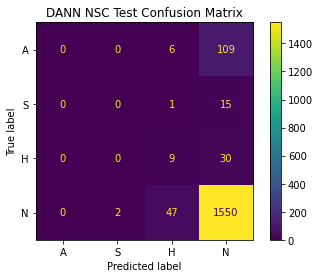

In [108]:
disp.plot()
plt.title("DANN NSC Test Confusion Matrix")
plt.show()

In [111]:
val_dataset = MSP_podcast_val['train']

In [112]:
all_batches_MSP = create_batches(val_dataset)

In [113]:
result_MSP = predict(all_batches_MSP)

In [114]:
get_metrics(result_MSP, val_dataset)

  0%|          | 0/652 [00:00<?, ?it/s]

  0%|          | 0/5213 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       621
           1     1.0000    0.0033    0.0066       302
           2     0.5038    0.0508    0.0922      1320
           3     0.0000    0.0000    0.0000       441
           4     0.4928    0.9897    0.6580      2529

    accuracy                         0.4932      5213
   macro avg     0.3993    0.2088    0.1514      5213
weighted avg     0.4246    0.4932    0.3429      5213

F1 score:
tensor(0.3429)


In [115]:
cm2 = get_confusion_matrix(result_MSP, val_dataset)

  0%|          | 0/652 [00:00<?, ?it/s]

  0%|          | 0/5213 [00:00<?, ?it/s]

[[   0    0   22    0  599]
 [   0    1    2    0  299]
 [   0    0   67    0 1253]
 [   0    0   16    0  425]
 [   0    0   26    0 2503]]


In [116]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=['A', 'S', 'H', 'D', 'N'])

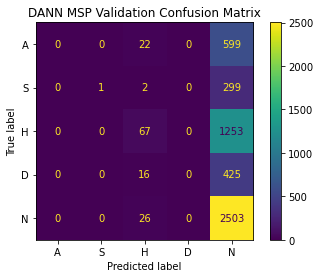

In [117]:
disp.plot()
plt.title("DANN MSP Validation Confusion Matrix")
plt.show()